In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd

data_CARS = {
    "2": {1133: pd.read_csv('CARS_PLS_DA_SNV_2/Confusion_Matrix_1133.csv'),
            12: pd.read_csv('CARS_PLS_DA_SNV_2/Confusion_Matrix_12.csv'),
             6: pd.read_csv('CARS_PLS_DA_SNV_2/Confusion_Matrix_6.csv')},
    "3": {1133: pd.read_csv('CARS_PLS_DA_SNV_3/Confusion_Matrix_1133.csv'),
            25: pd.read_csv('CARS_PLS_DA_SNV_3/Confusion_Matrix_25.csv'),
            19: pd.read_csv('CARS_PLS_DA_SNV_3/Confusion_Matrix_19.csv')},
    "4": {1133: pd.read_csv('CARS_PLS_DA_SNV_4/Confusion_Matrix_1133.csv'),
            34: pd.read_csv('CARS_PLS_DA_SNV_4/Confusion_Matrix_34.csv'),
            19: pd.read_csv('CARS_PLS_DA_SNV_4/Confusion_Matrix_19.csv')}
}

data_CCARS = {
    "2": {1133: pd.read_csv('CARS_PLS_DA_SNV_calibration_2/Confusion_Matrix_1133.csv'),
            10: pd.read_csv('CARS_PLS_DA_SNV_calibration_2/Confusion_Matrix_10.csv'),
             6: pd.read_csv('CARS_PLS_DA_SNV_calibration_2/Confusion_Matrix_6.csv')},
    "3": {1133: pd.read_csv('CARS_PLS_DA_SNV_calibration_3/Confusion_Matrix_1133.csv'),
            30: pd.read_csv('CARS_PLS_DA_SNV_calibration_3/Confusion_Matrix_30.csv'),
            20: pd.read_csv('CARS_PLS_DA_SNV_calibration_3/Confusion_Matrix_20.csv')},
    "4": {1133: pd.read_csv('CARS_PLS_DA_SNV_calibration_4/Confusion_Matrix_1133.csv'),
            19: pd.read_csv('CARS_PLS_DA_SNV_calibration_4/Confusion_Matrix_19.csv')}
}

In [2]:
def plot_confusion_matrix(ax, entry, n_wavelenghts, pos_count, neg_count):
    """
    Plots the confusion matrix as a heatmap on the given Axes.
    The matrix is arranged as:
    
                     Predicted
                [0]         [1]
    Actual [0]  TP          FN 
           [1]  FP          TN
    
    A title is drawn indicating the number of wavelengths.
    The color scale is fixed with vmin=0 and vmax = max(pos_count, neg_count).
    The cell annotation text color is chosen dynamically based on the cell’s brightness.
    """    
    matrix = np.array(entry[['Healty', 'Unhealty']].values)
    
    vmax = max(pos_count, neg_count)
    im = ax.imshow(matrix, cmap='viridis', vmin=0, vmax=vmax)
    
    # Annotate each cell with text using dynamic color based on cell brightness.
    for i in range(2):
        for j in range(2):
            value = matrix[i, j]
            norm_val = value / vmax if vmax else 0
            cell_color = cm.viridis(norm_val)
            r, g, b, _ = cell_color
            luminance = 0.299*r + 0.587*g + 0.114*b
            text_color = 'white' if luminance < 0.5 else 'black'
            ax.text(j, i, f"{value}", ha='center', va='center', color=text_color, fontsize=18)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_title(f"{n_wavelenghts} Wavelengths", fontsize=20)
    return im

def plot_all_groups(type_data, pos_count, neg_count, pdf_filename):
    # Order groups by PLS components (e.g., "2", "3", "4")
    pls_groups = sorted(type_data.keys(), key=lambda x: int(x))
    n_rows = len(pls_groups)
    n_cols = max(len(type_data[pls]) for pls in pls_groups)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
    if n_rows == 1:
        axs = np.array([axs])
    if n_cols == 1:
        axs = np.expand_dims(axs, axis=1)
    
    ims = []  # Collect image handles for colorbar scaling
    
    for r, pls in enumerate(pls_groups):
        group_entries = type_data[pls]
        wavelengths = list(group_entries.keys())

        for c in range(n_cols):
            ax = axs[r, c]
            if c < len(group_entries):
                w = wavelengths[c]
                im = plot_confusion_matrix(ax, group_entries[w], w, pos_count, neg_count)
                ims.append(im)
            else:
                ax.axis('off')
            
            # Set x tick labels on the last row only.
            if r == n_rows - 1:
                ax.set_xticklabels(["Healtty", "Unhealty"], rotation=45, ha='right', fontsize=18)
            else:
                ax.set_xticklabels([])
            
            # Set y tick labels on the first column only.
            if c == 0:
                ax.set_yticklabels(["Healtty", "Unhealty"], fontsize=18)
            else:
                ax.set_yticklabels([])
        
        # Add a letter annotation for the row.
        letter = chr(65 + r)  # "A", "B", "C", etc.
        # Place the letter further to the left using a bounding box with background "#31688e".
        axs[r, 0].text(-0.45, 1.15, letter,
                       transform=axs[r, 0].transAxes,
                       fontsize=18, fontweight='bold', color='white',
                       bbox=dict(facecolor="#31688e", edgecolor='none', pad=4))
    
    # Adjust layout to leave room on the right for the colorbar.
    plt.tight_layout(rect=[0, 0, 0.85, 0.95], w_pad=0.05, h_pad=2)
    
    # Create a fixed axis for the colorbar.
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    norm = colors.Normalize(vmin=0, vmax=max(pos_count, neg_count))
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    
    # Create a fixed accis for the "Predicted" and "Actual" labels.
    fig.text(0.5, -0.02, 'Predicted', ha='center', fontsize=25)
    fig.text(-0.005, 0.5, 'Actual', va='center', rotation='vertical', fontsize=25)
    
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

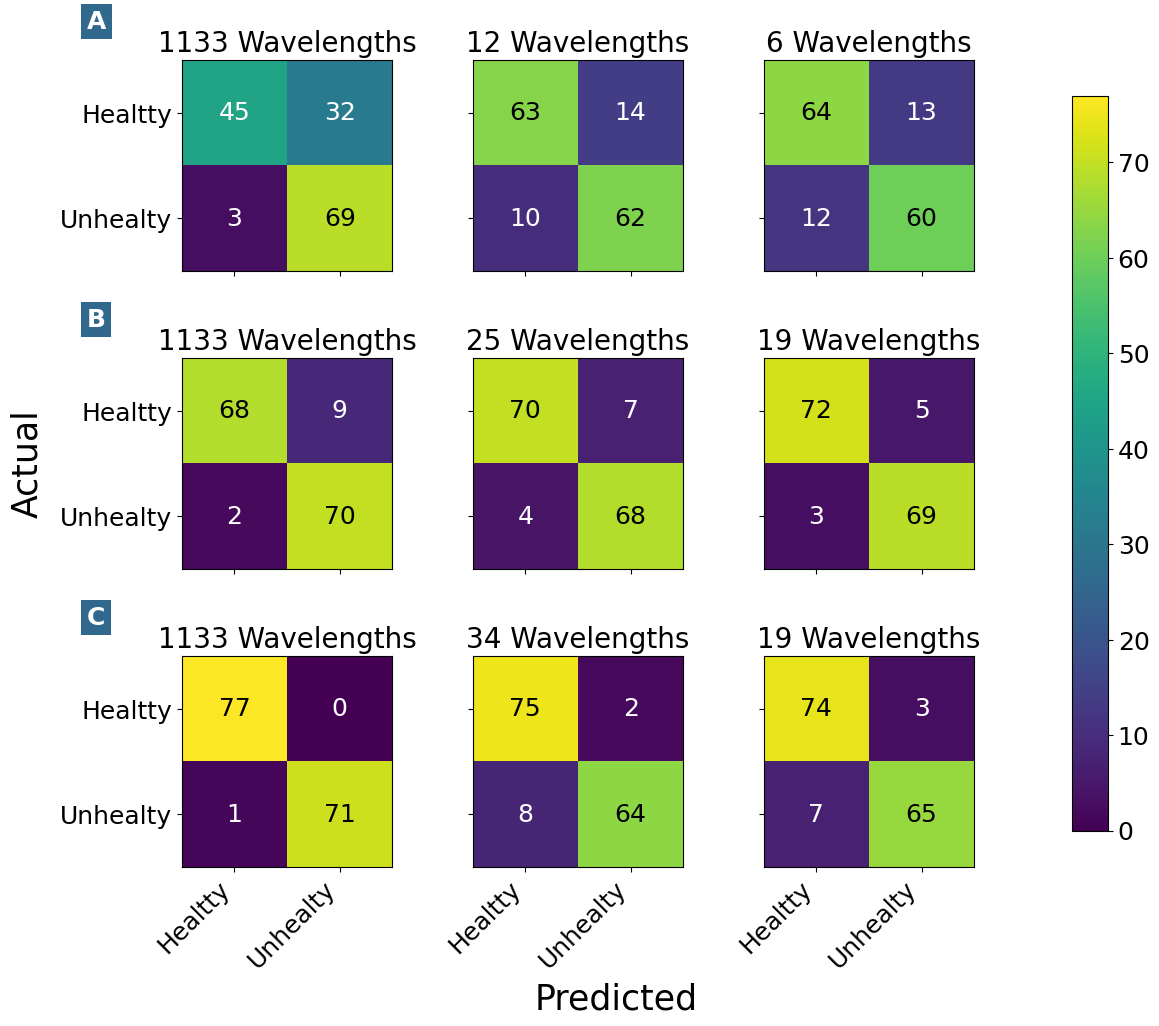

/tmp/ipykernel_552913/3251124234.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Healtty", "Unhealty"], rotation=45, ha='right', fontsize=18)


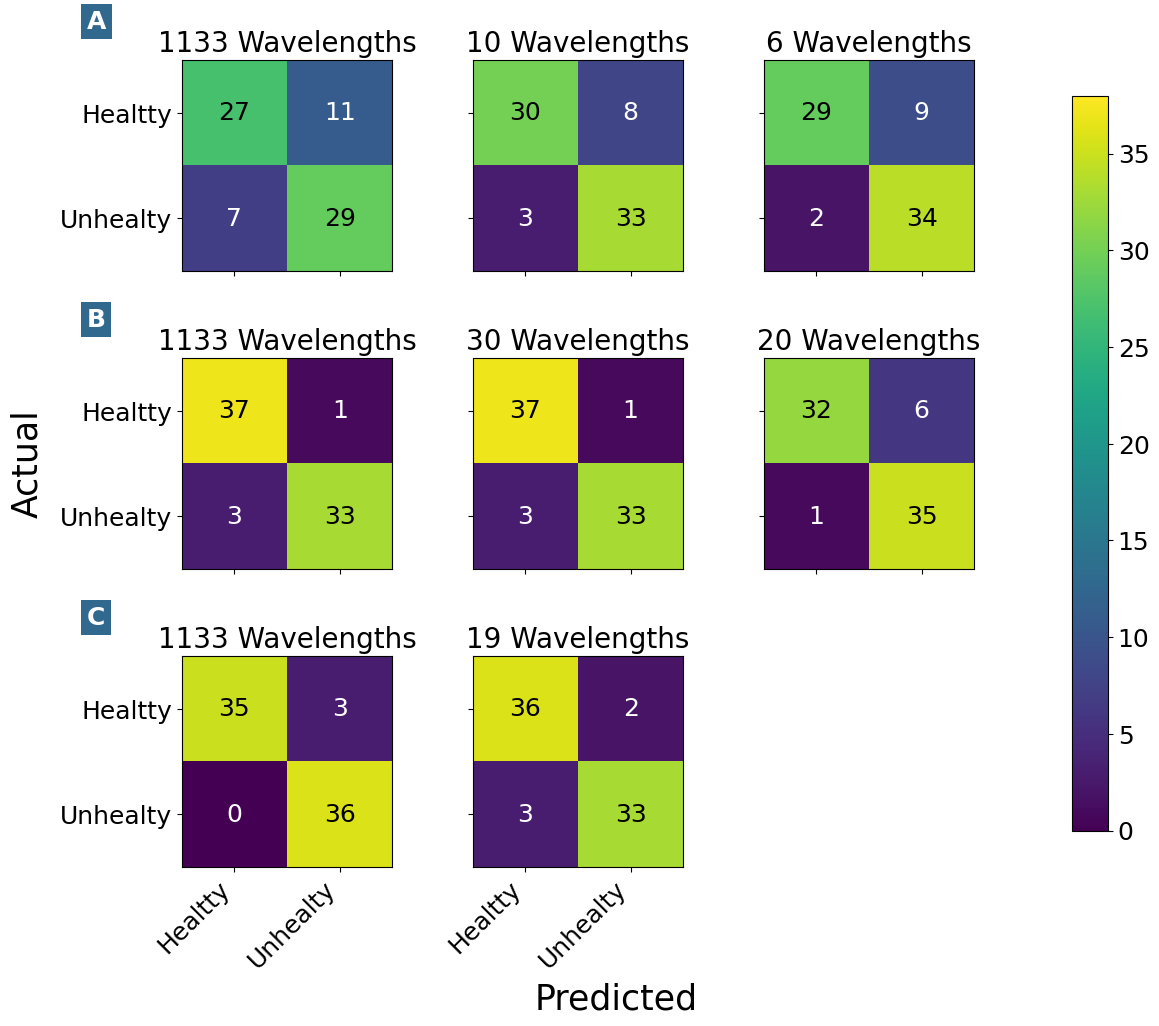

In [3]:
# creae folder if it does not exist
import os
if not os.path.exists('plots'):
    os.makedirs('plots')

plot_all_groups(data_CARS,  pos_count=77, neg_count=72, pdf_filename='plots/CARS_confusion_matrix.pdf')
plot_all_groups(data_CCARS, pos_count=38, neg_count=36, pdf_filename='plots/CCARS_confusion_matrix.pdf')